# Model Training, Testing & Deployment
In this notebook, we train an XGBoost model to predict the disease based on symptoms of a patient. We test the model, add it to model registry and deploy it as an endpoint.

In [84]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bucket = "disease-classification-12052025"

In [3]:
train_file = "train.csv"
val_file = "val.csv"
test_file = "test.csv"

## Training XGBoost Model

In [4]:
region = sagemaker.Session().boto_region_name
print(region)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
us-east-2


In [5]:
role = sagemaker.get_execution_role()

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [6]:
s3_output_location = f"s3://{bucket}/model/"

### Retrieve XGBoost container and setup an estimator

In [7]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

In [8]:
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"
)
print(container)

257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.7-1


In [9]:
xgb_estimator=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.Environment


In [10]:
xgb_estimator.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "multi:softmax",
    num_class = 41,
    num_round = 1000
)

### Configure a data input flow for training

In [11]:
from sagemaker.session import TrainingInput

In [12]:
train_input = TrainingInput("s3://{}/{}/{}".format(bucket, "data", train_file), content_type="csv")
val_input = TrainingInput("s3://{}/{}/{}".format(bucket, "data", val_file), content_type="csv")

### Train the model

In [13]:
xgb_estimator.fit({"train": train_input, "validation": val_input}, wait=True)

2026-01-02 19:40:21 Starting - Starting the training job...
2026-01-02 19:40:47 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2026-01-02 19:41:08 Downloading - Downloading input data...
2026-01-02 19:41:48 Downloading - Downloading the training image......
2026-01-02 19:42:48 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-02 19:42:47.094 ip-10-0-183-158.us-east-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-01-02 19:42:47.168 ip-10-0-183-158.us-east-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled pr

In [14]:
# Path where model is stored
xgb_estimator.model_data

's3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/output/model.tar.gz'

In [15]:
# View info of the estimator
xgb_estimator.__dict__

{'image_uri': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.7-1',
 '_hyperparameters': {'max_depth': 5,
  'eta': 0.2,
  'gamma': 4,
  'min_child_weight': 6,
  'subsample': 0.7,
  'objective': 'multi:softmax',
  'num_class': 41,
  'num_round': 1000},
 'instance_count': 1,
 'instance_type': 'ml.m4.xlarge',
 'keep_alive_period_in_seconds': None,
 'instance_groups': None,
 'volume_size': 5,
 'max_run': 86400,
 'input_mode': 'File',
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'source_dir': None,
 'git_config': None,
 'container_log_level': 20,
 'code_location': None,
 'entry_point': None,
 'dependencies': [],
 'uploaded_code': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7fed09896150>,
 'tags': None,
 'base_job_name': 'sagemaker-xgboost',
 '_current_job_name': 'sagemaker-xgboost-2026-01-02-19-40-16-206',
 'output_path': 's3://disease-classification-12052025/model/',
 'la

In [16]:
rule_output_path = xgb_estimator.output_path + xgb_estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2026-01-02 19:46:27      40666 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
2026-01-02 19:46:27       2839 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
2026-01-02 19:46:27      24174 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json
2026-01-02 19:46:27      74673 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
2026-01-02 19:46:27       3015 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json
2026-01-02 19:46:27      37338 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/LossData.json
2026-01-02 19:46:27        575 model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostR

In [17]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost_report.html to CreateXgboostReport/xgboost_report.html
download: s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json to CreateXgboostReport/xgboost-reports/LabelsDistribution.json
download: s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/rule-output/CreateXgboostReport/xgboost_report.ipynb to

In [18]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/mnt/custom-file-systems/s3/shared/CreateXgboostReport/xgboost_report.html

In [19]:
profiler_report_name = [rule["RuleConfigurationName"] 
                        for rule in xgb_estimator.latest_training_job.rule_job_summary() 
                        if "Profiler" in rule["RuleConfigurationName"]][0]
profiler_report_name
display("Click link below to view the profiler report", FileLink(profiler_report_name+"/profiler-output/profiler-report.html"))

'Click link below to view the profiler report'

/mnt/custom-file-systems/s3/shared/ProfilerReport/profiler-output/profiler-report.html

In [20]:
# Info on the model training
xgb_estimator.latest_training_job.describe()

{'TrainingJobName': 'sagemaker-xgboost-2026-01-02-19-40-16-206',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:657480822269:training-job/sagemaker-xgboost-2026-01-02-19-40-16-206',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://disease-classification-12052025/model/sagemaker-xgboost-2026-01-02-19-40-16-206/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '0.2',
  'gamma': '4',
  'max_depth': '5',
  'min_child_weight': '6',
  'num_class': '41',
  'num_round': '1000',
  'objective': 'multi:softmax',
  'subsample': '0.7'},
 'AlgorithmSpecification': {'TrainingImage': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'},
   {'Name': 'train:merror',
    'Regex': '.*\\[[0-9]+\\].*#011train-merror:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)

## Model Testing using Batch Transform Job
In this section, we make predictions on the test dataset using the trained model with a batch transform job. Then, various performance metrics are calculated

In [21]:
test_data = pd.read_csv(f"s3://{bucket}/data/{test_file}")
test_data.head()

,15,1,1.1,1.2,0,0.1,0.2,0.3,0.4,0.5,...,0.118,0.119,0.120,0.121,0.122,0.123,0.124,0.125,0.126,0.127
0,4,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the file to use in batch transform job, the label should be removed.

In [22]:
test_data = test_data.iloc[:, 1:]                         # drop first column

In [23]:
test_data.head(2)

,1,1.1,1.2,0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.118,0.119,0.120,0.121,0.122,0.123,0.124,0.125,0.126,0.127
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
test_file_no_target = f"s3://{bucket}/data/test_file_no_target.csv"

In [25]:
test_data.to_csv(test_file_no_target, index=False, header=False)

In [26]:
batch_job = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/batch-output/"
)

batch_job.transform(
    data=test_file_no_target,
    content_type="text/csv"
)

batch_job.wait()

.............................../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-02:19:51:51:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-02:19:51:51:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-02:19:51:51:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|inv

The output has been written to the output_path specified and would be named after the input file name with an extension of '.out'. Next, we will read the output file and convert to a dataframe.

In [27]:
batch_transform_output = pd.read_csv(f"s3://{bucket}/batch-output/test_file_no_target.csv.out", sep=",", header=None)

In [28]:
batch_transform_output.head()

,0
0,4.0
1,16.0
2,9.0
3,14.0
4,33.0


## Computing Performance Metrics on Test Dataset

In [29]:
test_data_true = pd.read_csv(f"s3://{bucket}/data/{test_file}")

In [30]:
output_true = test_data_true.iloc[:,0]

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [32]:
# Calculate accuracy
accuracy = accuracy_score(output_true, batch_transform_output)

# Calculate precision
precision = precision_score(output_true, batch_transform_output, average='weighted')

# Calculate recall
recall = recall_score(output_true, batch_transform_output, average='weighted')

# Generate a confusion matrix
conf_matrix = confusion_matrix(output_true, batch_transform_output)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.975609756097561
Precision: 0.9634146341463414
Recall: 0.975609756097561


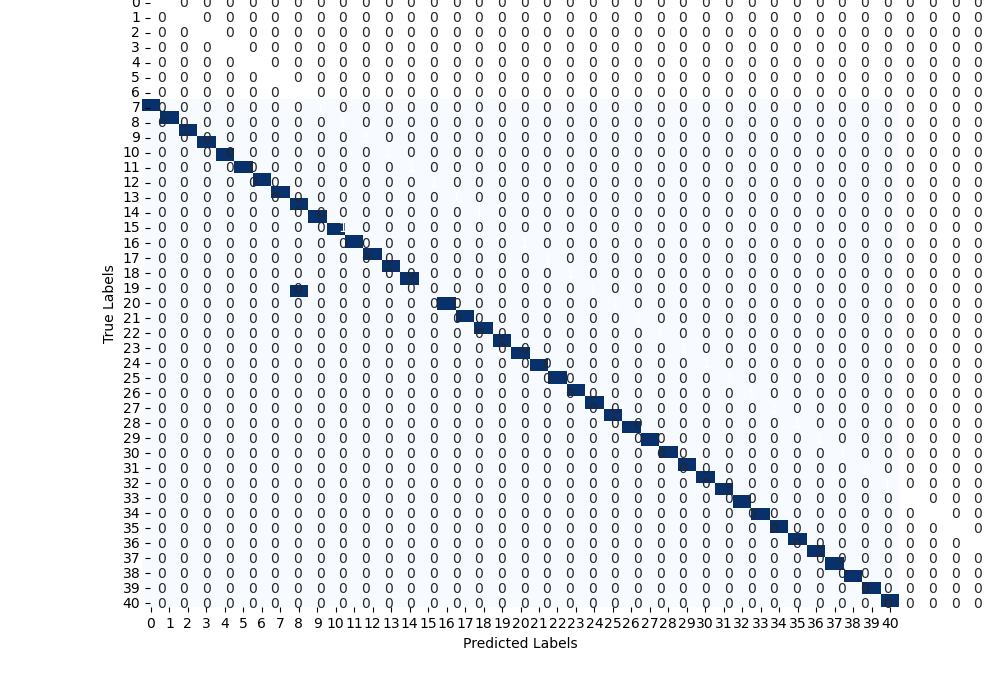

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Uploading the Model to Model Registry
We create a model package group and register the model package to it.

In [34]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sm_client = boto3.client('sagemaker', region_name=region)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [35]:
# Creating Model Package Group
model_package_group_name = "disease-classification-model-01012026"
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "Model to predict disease based on symptoms"
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-2:657480822269:model-package-group/disease-classification-model-01012026


In [80]:
metrics_test_data = {
  "classificationMetrics": {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1Score": 2*(precision*recall)/(precision + recall),
    "multiclassClassMetrics": []
    }
}
metrics_test_data

{'classificationMetrics': {'accuracy': 0.975609756097561,
  'precision': 0.9634146341463414,
  'recall': 0.975609756097561,
  'f1Score': 0.969473845681853,
  'multiclassClassMetrics': []}}

In [81]:
import json
# Convert to JSON
json_file = "/tmp/model_metrics.json"
with open(json_file, "w") as f:
    json.dump(metrics_test_data, f)

# Upload to S3
s3 = boto3.client("s3")
s3_key_info = "model-info/xgb_model_test_metrics.json"

s3.upload_file(json_file, bucket, s3_key_info)
s3_uri = f"s3://{bucket}/{s3_key_info}"

In [87]:
# Specify the model source
info = xgb_estimator.latest_training_job.describe()
model_url = info["ModelArtifacts"]["S3ModelArtifacts"]
modelpackage_inference_specification =  {
    "InferenceSpecification": {
      "Containers": [
         {
            "Image": container,
	    "ModelDataUrl": model_url
         }
      ],
      "SupportedContentTypes": [ "text/csv" ],
      "SupportedResponseMIMETypes": [ "text/csv" ],
   },
   "ModelMetrics" : {"ModelQuality": { 
           "Statistics": { 
            "ContentType": "application/json",
            "S3Uri": s3_uri
         }
      }
   }
 }

create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "XGBoost model to predict disease based on symptoms)",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-2:657480822269:model-package/disease-classification-model-01012026/9


In [88]:
# Change model approval status
sm_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved"  # Options: "Approved", "Rejected", "PendingManualApproval"
)

{'ModelPackageArn': 'arn:aws:sagemaker:us-east-2:657480822269:model-package/disease-classification-model-01012026/9',
 'ResponseMetadata': {'RequestId': '7f02aeff-e5e3-4e0f-9e67-9f7d9dd55777',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7f02aeff-e5e3-4e0f-9e67-9f7d9dd55777',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '116',
   'date': 'Fri, 02 Jan 2026 22:14:49 GMT'},
  'RetryAttempts': 0}}

## Deploying the Model for Real-time Inference
In this section, we will create a real-time endpoint for the model.

In [89]:
model = sagemaker.ModelPackage(role=role, 
                     model_package_arn=model_package_arn, 
                     sagemaker_session=sagemaker.Session())
model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
------!

## Real-time Inference
In this section, we invoke the endpoint to make real-time inference.

In [90]:
# List endpoints and find the most recent one
endpoints = sm_client.list_endpoints(SortBy='CreationTime', SortOrder='Descending')['Endpoints']
latest_endpoint_name = endpoints[0]['EndpointName']

In [93]:
# Creating a predictor object
predictor = sagemaker.Predictor(endpoint_name=latest_endpoint_name, sagemaker_session=sagemaker.Session())
# NOTE:  We could've done the following while deployment itself
# predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [100]:
test_data_real_time_inference = pd.read_csv(f"s3://{bucket}/data/{test_file}")
test_data_real_time_inference.iloc[2:5,:]

,15,1,1.1,1.2,0,0.1,0.2,0.3,0.4,0.5,...,0.118,0.119,0.120,0.121,0.122,0.123,0.124,0.125,0.126,0.127
2,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column is the real output. Hence, for the above 3 rows, the values should be 9, 14 and 33 respectively.

In [107]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set serializer/deserializer for CSV input and JSON output
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

In [111]:
# Convert each row to CSV string
rows = test_data_real_time_inference.iloc[2:5,1:].values.tolist()
csv_rows = [",".join(map(str, row)) for row in rows]

In [113]:
predictions = [predictor.predict(row) for row in csv_rows]

In [115]:
print("Prediction: ", predictions)

Prediction:  [{'predictions': [{'score': 9.0}]}, {'predictions': [{'score': 14.0}]}, {'predictions': [{'score': 33.0}]}]


The model has thus predicted 9, 14 and 33 as outputs. This matches with the test dataset as seen earlier.